In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import random
from tqdm import tqdm
from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import resize
import matplotlib.pyplot as plt
from load_data import load_path, tf_data, get_np_images

print(tf.version.VERSION)

2.3.0


In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Defining parameters

h = 256
w = 256
channels = 3
batch_size = 8
buffer_size = 100
num_epochs = 200
lr = 1e-3
seed = 42
np.random.seed = seed

In [4]:
train_path='DDRIVE/Train/Image'
train_mask_path='DDRIVE/Train/Mask'
test_path='DDRIVE/Train/Image'
test_mask_path='DDRIVE/Train/Mask'

X_train, Y_train = load_path(train_path, train_mask_path)
X_test, Y_test = load_path(test_path, test_mask_path)

In [5]:
Train = tf_data(X_train, Y_train, buffer_size, batch_size, num_epochs)
Test = tf_data(X_test, Y_test, buffer_size, batch_size, num_epochs)

In [ ]:
for x, y in Train:
    f, plot = plt.subplots(1,2)
    plot[0].imshow(x[0])
    plot[1].imshow(y[0])
    plt.show();
    
for x, y in Test:
    f, plot = plt.subplots(1,2)
    plot[0].imshow(x[0])
    plot[1].imshow(y[0])
    plt.show();

In [6]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from Metrics import dice_coef, dice_loss, iou

In [7]:
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [8]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x

In [9]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [10]:
def build_vgg16_unet(input_shape):
    inputs = Input(input_shape)
    
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """ 
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG16_U-Net")  
    return model

In [11]:
train_steps = len(X_train)//batch_size
test_steps = len(X_test)//batch_size
if len(X_train) % batch_size != 0:
    train_steps += 1
if len(X_test) % batch_size != 0:
    test_steps += 1

input_shape = (h, w, 3)
model = build_vgg16_unet(input_shape)
model.compile(optimizer = Adam(lr), loss = dice_loss, metrics = [dice_coef, iou, Accuracy(), Recall(), Precision()])
model.summary()

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
________________________________________________________________________________________

In [12]:
#Model Checkpoint
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_retina', verbose = 1, save_best_only = True)

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=200, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
]

results=model.fit(
    Train,
    validation_data = Test, 
    batch_size = batch_size, 
    steps_per_epoch = train_steps,
    validation_steps = test_steps,
    epochs = num_epochs, 
    callbacks=callbacks)

Epoch 1/200
1/3 [=========>....................] - ETA: 0s - loss: 0.8347 - dice_coef: 0.1653 - iou: 0.0901 - accuracy: 0.0000e+00 - recall: 0.8109 - precision: 0.1080WARNING:tensorflow:From C:\Users\User\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
3/3 [==============================] - 6s 2s/step - loss: 0.7642 - dice_coef: 0.2500 - iou: 0.1444 - accuracy: 0.0000e+00 - recall: 0.9020 - precision: 0.1425 - val_loss: 0.8363 - val_dice_coef: 0.1597 - val_iou: 0.0869 - val_accuracy: 0.0808 - val_recall: 1.0000 - val_precision: 0.0892
Epoch 2/200
3/3 [==============================] - 8s 3s/step - loss: 0.6575 - dice_coef: 0.3447 - iou: 0.2084 - accuracy: 0.0024 - recall: 0.8719 - precision: 0.3011 - val_loss: 0.8363 - val_dice_coef: 0.1644 - val_iou: 0.0896 - val_accuracy: 0.0892 

Epoch 27/200
3/3 [==============================] - 1s 491ms/step - loss: 0.2726 - dice_coef: 0.7268 - iou: 0.5708 - accuracy: 0.0180 - recall: 0.8013 - precision: 0.7887 - val_loss: 0.7546 - val_dice_coef: 0.2448 - val_iou: 0.1394 - val_accuracy: 0.0486 - val_recall: 0.9721 - val_precision: 0.1526
Epoch 28/200
3/3 [==============================] - 2s 561ms/step - loss: 0.2667 - dice_coef: 0.7326 - iou: 0.5781 - accuracy: 0.0189 - recall: 0.7987 - precision: 0.7941 - val_loss: 0.7900 - val_dice_coef: 0.2105 - val_iou: 0.1176 - val_accuracy: 0.0658 - val_recall: 0.9959 - val_precision: 0.1223
Epoch 29/200
3/3 [==============================] - 1s 479ms/step - loss: 0.2607 - dice_coef: 0.7403 - iou: 0.5876 - accuracy: 0.0190 - recall: 0.8066 - precision: 0.7905 - val_loss: 0.7044 - val_dice_coef: 0.2892 - val_iou: 0.1693 - val_accuracy: 0.0403 - val_recall: 0.9544 - val_precision: 0.2356
Epoch 30/200
3/3 [==============================] - 2s 690ms/step - loss: 0.2570 - dice_coef: 0.7415

3/3 [==============================] - 2s 533ms/step - loss: 0.1643 - dice_coef: 0.8364 - iou: 0.7188 - accuracy: 0.0292 - recall: 0.8383 - precision: 0.8824 - val_loss: 0.3358 - val_dice_coef: 0.6601 - val_iou: 0.4928 - val_accuracy: 6.0120e-04 - val_recall: 0.6631 - val_precision: 0.8505
Epoch 55/200
3/3 [==============================] - 2s 508ms/step - loss: 0.1623 - dice_coef: 0.8371 - iou: 0.7199 - accuracy: 0.0296 - recall: 0.8585 - precision: 0.8634 - val_loss: 0.3126 - val_dice_coef: 0.6893 - val_iou: 0.5259 - val_accuracy: 0.0010 - val_recall: 0.6868 - val_precision: 0.8683
Epoch 56/200
3/3 [==============================] - 2s 513ms/step - loss: 0.1645 - dice_coef: 0.8357 - iou: 0.7178 - accuracy: 0.0303 - recall: 0.8456 - precision: 0.8695 - val_loss: 0.3532 - val_dice_coef: 0.6487 - val_iou: 0.4801 - val_accuracy: 2.1973e-04 - val_recall: 0.6219 - val_precision: 0.8644
Epoch 57/200
3/3 [==============================] - 2s 555ms/step - loss: 0.1609 - dice_coef: 0.8390 - io

3/3 [==============================] - 2s 679ms/step - loss: 0.0976 - dice_coef: 0.9023 - iou: 0.8220 - accuracy: 0.0366 - recall: 0.8885 - precision: 0.9450 - val_loss: 0.2632 - val_dice_coef: 0.7343 - val_iou: 0.5804 - val_accuracy: 0.0034 - val_recall: 0.6345 - val_precision: 0.9368
Epoch 82/200
3/3 [==============================] - 1s 487ms/step - loss: 0.0948 - dice_coef: 0.9041 - iou: 0.8250 - accuracy: 0.0384 - recall: 0.9001 - precision: 0.9365 - val_loss: 0.2641 - val_dice_coef: 0.7364 - val_iou: 0.5828 - val_accuracy: 0.0040 - val_recall: 0.6311 - val_precision: 0.9385
Epoch 83/200
3/3 [==============================] - 2s 512ms/step - loss: 0.0913 - dice_coef: 0.9102 - iou: 0.8352 - accuracy: 0.0376 - recall: 0.8975 - precision: 0.9465 - val_loss: 0.2753 - val_dice_coef: 0.7250 - val_iou: 0.5687 - val_accuracy: 0.0032 - val_recall: 0.6096 - val_precision: 0.9447
Epoch 84/200
3/3 [==============================] - 2s 516ms/step - loss: 0.0887 - dice_coef: 0.9123 - iou: 0.838

3/3 [==============================] - 1s 479ms/step - loss: 0.0684 - dice_coef: 0.9311 - iou: 0.8710 - accuracy: 0.0436 - recall: 0.9156 - precision: 0.9632 - val_loss: 0.1626 - val_dice_coef: 0.8375 - val_iou: 0.7205 - val_accuracy: 0.0186 - val_recall: 0.7580 - val_precision: 0.9586
Epoch 109/200
3/3 [==============================] - 2s 513ms/step - loss: 0.0667 - dice_coef: 0.9336 - iou: 0.8754 - accuracy: 0.0437 - recall: 0.9169 - precision: 0.9653 - val_loss: 0.1784 - val_dice_coef: 0.8212 - val_iou: 0.6966 - val_accuracy: 0.0177 - val_recall: 0.7306 - val_precision: 0.9602
Epoch 110/200
3/3 [==============================] - 2s 698ms/step - loss: 0.0654 - dice_coef: 0.9336 - iou: 0.8755 - accuracy: 0.0423 - recall: 0.9161 - precision: 0.9680 - val_loss: 0.1812 - val_dice_coef: 0.8171 - val_iou: 0.6908 - val_accuracy: 0.0172 - val_recall: 0.7244 - val_precision: 0.9612
Epoch 111/200
3/3 [==============================] - 2s 512ms/step - loss: 0.0640 - dice_coef: 0.9375 - iou: 0.

3/3 [==============================] - 2s 517ms/step - loss: 0.0551 - dice_coef: 0.9446 - iou: 0.8950 - accuracy: 0.0455 - recall: 0.9234 - precision: 0.9734 - val_loss: 0.0913 - val_dice_coef: 0.9073 - val_iou: 0.8304 - val_accuracy: 0.0293 - val_recall: 0.8658 - val_precision: 0.9720
Epoch 136/200
3/3 [==============================] - 2s 512ms/step - loss: 0.0551 - dice_coef: 0.9444 - iou: 0.8946 - accuracy: 0.0461 - recall: 0.9235 - precision: 0.9735 - val_loss: 0.0860 - val_dice_coef: 0.9140 - val_iou: 0.8416 - val_accuracy: 0.0301 - val_recall: 0.8771 - val_precision: 0.9717
Epoch 137/200
3/3 [==============================] - 2s 511ms/step - loss: 0.0550 - dice_coef: 0.9439 - iou: 0.8938 - accuracy: 0.0468 - recall: 0.9236 - precision: 0.9735 - val_loss: 0.0803 - val_dice_coef: 0.9191 - val_iou: 0.8503 - val_accuracy: 0.0313 - val_recall: 0.8860 - val_precision: 0.9723
Epoch 138/200
3/3 [==============================] - 2s 514ms/step - loss: 0.0549 - dice_coef: 0.9450 - iou: 0.

3/3 [==============================] - 1s 480ms/step - loss: 0.0524 - dice_coef: 0.9479 - iou: 0.9010 - accuracy: 0.0474 - recall: 0.9258 - precision: 0.9747 - val_loss: 0.0593 - val_dice_coef: 0.9406 - val_iou: 0.8878 - val_accuracy: 0.0365 - val_recall: 0.9195 - val_precision: 0.9747
Epoch 163/200
3/3 [==============================] - 1s 483ms/step - loss: 0.0522 - dice_coef: 0.9482 - iou: 0.9015 - accuracy: 0.0474 - recall: 0.9260 - precision: 0.9748 - val_loss: 0.0592 - val_dice_coef: 0.9402 - val_iou: 0.8872 - val_accuracy: 0.0366 - val_recall: 0.9192 - val_precision: 0.9748
Epoch 164/200
3/3 [==============================] - 1s 490ms/step - loss: 0.0524 - dice_coef: 0.9479 - iou: 0.9010 - accuracy: 0.0474 - recall: 0.9260 - precision: 0.9748 - val_loss: 0.0585 - val_dice_coef: 0.9425 - val_iou: 0.8912 - val_accuracy: 0.0367 - val_recall: 0.9209 - val_precision: 0.9749
Epoch 165/200
3/3 [==============================] - 2s 511ms/step - loss: 0.0522 - dice_coef: 0.9468 - iou: 0.

3/3 [==============================] - 1s 489ms/step - loss: 0.0508 - dice_coef: 0.9499 - iou: 0.9046 - accuracy: 0.0486 - recall: 0.9272 - precision: 0.9754 - val_loss: 0.0516 - val_dice_coef: 0.9470 - val_iou: 0.8994 - val_accuracy: 0.0423 - val_recall: 0.9271 - val_precision: 0.9755
Epoch 190/200
3/3 [==============================] - 2s 501ms/step - loss: 0.0508 - dice_coef: 0.9509 - iou: 0.9065 - accuracy: 0.0486 - recall: 0.9272 - precision: 0.9755 - val_loss: 0.0514 - val_dice_coef: 0.9492 - val_iou: 0.9032 - val_accuracy: 0.0421 - val_recall: 0.9272 - val_precision: 0.9755
Epoch 191/200
3/3 [==============================] - 2s 506ms/step - loss: 0.0507 - dice_coef: 0.9495 - iou: 0.9039 - accuracy: 0.0486 - recall: 0.9273 - precision: 0.9755 - val_loss: 0.0513 - val_dice_coef: 0.9477 - val_iou: 0.9006 - val_accuracy: 0.0421 - val_recall: 0.9272 - val_precision: 0.9755
Epoch 192/200
3/3 [==============================] - 1s 464ms/step - loss: 0.0507 - dice_coef: 0.9491 - iou: 0.

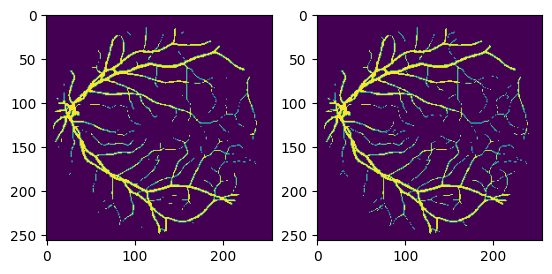

In [13]:
x, y = get_np_images(X_train, Y_train)
y_pred = model.predict(np.expand_dims(x[0], axis = 0))
# y_pred = y_pred > 0.5
# y_pred = y_pred.astype(np.int32)
f, plot = plt.subplots(1,2)
plot[0].imshow(y_pred[0])
plot[1].imshow(y[0])
plt.show();